In [1]:
import spectral as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import sys
import scipy.io


sys.path.append('../')
from preprocessing import *
from plotting_parameters import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, Bbox
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams, cycler
# matplotlib.use("wxAgg")
%matplotlib inline
set_plotting_style("latex")
# set_plotting_style("default")

In [2]:
dataset_path = "../../datasets/piglet/"
xlsx_path = "overview.xlsx"
df = pd.read_excel(xlsx_path, sheet_name="Sheet2", engine="openpyxl")

### "Good" spectras from the first recording day before and after processing

In [164]:
def l1_normalize(img, threshold=0):
    '''
    Normalize the image spectral signatures pixel-wise to unit L1 norm.
    Spectral dimension must be the last dimension.
    input:
        img: image to normalize, shape (...,k) where k is the number of bands and ... are the spatial or time dimensions
        threshold: percentile of L1 norm for which the spectrum is set to zero
    output:
        image as np.array
    '''
    img = get_array(img)
    norm = np.linalg.norm(img, ord=1, axis=-1, keepdims=True)

    # set pixels with low norm to zero
    norm_min = np.percentile(norm, threshold)
    img[np.where(norm<norm_min),:] = 0

    img = np.divide(img, norm)
    return img

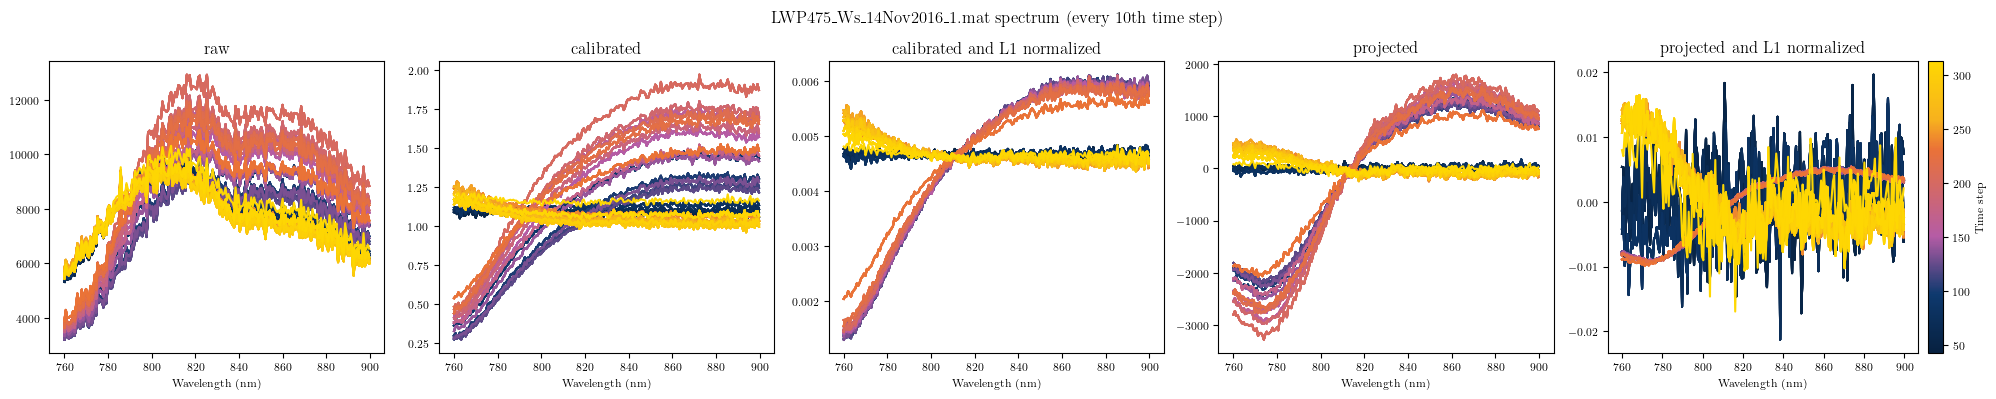

In [166]:
for i in range(len(df)):

    start = df.HI_start_idx[i] - 30
    end = df.HI_end_idx[i] + 100
    time_steps = np.arange(start,end,10, dtype=int)

    piglet = df.piglet[i]

    img_mat = scipy.io.loadmat(dataset_path + piglet + "/" + df.spectrum[i])
    band_centers = np.asarray(img_mat['wavelengths'].astype(float)).squeeze()
    spectr = img_mat['spectralDataAll'].astype(float)[:,time_steps].T # shape (time_steps.shape[0], k)
    white_ref= img_mat['refIntensity'].astype(float) # shape (k,m)
    dark_ref = scipy.io.loadmat(dataset_path + piglet + "/" + df.darkCount[i])["DarkCount"].astype(float) # shape (k,n)
    concentrations = img_mat['allConcent'].astype(float)

    # average dark and white reference and add dimension for shape (1,k)
    white_ref = np.mean(white_ref, axis=-1)[np.newaxis, :]
    dark_ref = np.mean(dark_ref, axis=-1)[np.newaxis, :]
    
    # extract wavelengths between 760 and 900
    band_limits = [760, 900]
    spectr, _ = band_removal(spectr, band_limits, band_centers)
    white_ref, _ = band_removal(white_ref, band_limits, band_centers)
    dark_ref, band_centers_new = band_removal(dark_ref, band_limits, band_centers)

    # smooth the spectra
    # m = 10
    # spectr, white_ref, dark_ref = smooth_spectral(spectr, m), smooth_spectral(white_ref, m), smooth_spectral(dark_ref, m)

    # plot the spectrum
    fig, axs = plt.subplots(1,5,figsize=(20, 4))
    # raw spectrum
    plot_spectrum(spectr, band_centers_new, fig, axs[0])
    axs[0].set_title(f"raw", fontsize=12)
    # calibrated spectrum
    sprectr_calib = calibrate_img(spectr, white_ref, dark_ref)
    plot_spectrum(sprectr_calib, band_centers_new, fig, axs[1])
    axs[1].set_title(f"calibrated", fontsize=12)
    # calibrated spectrum normalized
    sprectr_calib_norm = l1_normalize(sprectr_calib)
    plot_spectrum(sprectr_calib_norm, band_centers_new, fig, axs[2])
    axs[2].set_title(f"calibrated and L1 normalized", fontsize=12)
    # projected spectrum
    spectr_proj = project_img(spectr, white_ref, dark_ref)
    plot_spectrum(spectr_proj, band_centers_new, fig, axs[3])
    axs[3].set_title(f"projected", fontsize=12)
    # projected spectrum normalized
    spectr_proj_norm = l1_normalize(spectr_proj, threshold=0)
    plot = plot_spectrum(spectr_proj_norm, band_centers_new, fig, axs[4])
    axs[4].set_title(f"projected and L1 normalized", fontsize=12)
    # add descriptions
    fig.suptitle(f"{df.spectrum[i]} spectrum (every 10th time step)", fontsize=12)
    sm = plt.cm.ScalarMappable(cmap=tum_cmap, norm=plt.Normalize(min(time_steps), max(time_steps)))
    sm.set_array(np.arange(min(time_steps), max(time_steps)))  # Specify the array directly
    divider = make_axes_locatable(axs[4])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(sm, cax=cax, label=r"Time step")
    plt.tight_layout()

    break

### Intra patient data

change of spectra over time

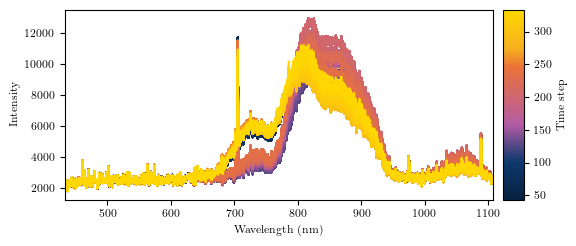

In [170]:
for i in range(len(df)):

    start = df.HI_start_idx[i] - 30 # 5min before HI
    end = df.HI_end_idx[i] + 120 # 15min after end of HI
    time_steps = np.arange(start,end,10, dtype=int)

    img_mat = scipy.io.loadmat(dataset_path + df.piglet[i] + "/" + df.spectrum[i])
    band_centers = np.asarray(img_mat['wavelengths'].astype(float)).squeeze()
    spectr = img_mat['spectralDataAll'].astype(float)[:,time_steps].T # shape (time_steps.shape[0], k)

    # # plot the spectrum
    fig, ax = plt.subplots(figsize=(5.81,2.5))

    plot_spectrum(spectr, band_centers, fig, ax)
    ax.set_ylabel('Intensity')
    ax.set_xlim([band_centers[0], band_centers[-1]])
    # fig.suptitle(f"{df.piglet[i]} spectrum (every 10th time step)", fontsize=12)
    sm = plt.cm.ScalarMappable(cmap=tum_cmap, norm=plt.Normalize(min(time_steps), max(time_steps)))
    sm.set_array(np.arange(min(time_steps), max(time_steps)))  # Specify the array directly
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(sm, cax=cax, label=r"Time step")
    plt.tight_layout()

    # plt.savefig(f"../../figures/piglet_{df.piglet[i]}_raw_spectra.svg", format='svg', bbox_inches="tight")
    break

concentration change

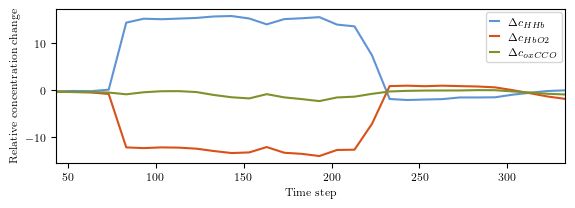

In [168]:
for i in range(len(df)):

    start = df.HI_start_idx[i] - 30 # 5min before HI
    end = df.HI_end_idx[i] + 120 # 15min after end of HI
    time_steps = np.arange(start,end,10, dtype=int)

    img_mat = scipy.io.loadmat(dataset_path + df.piglet[i] + "/" + df.spectrum[i])
    concentrations = img_mat['allConcent'].astype(float)

    # plot the concentrations
    fig, ax = plt.subplots(figsize=(6.57,2))  # full page width
    # fig, ax = plt.subplots(figsize=(2.72,2))    # half page width
    rcParams["axes.prop_cycle"] = cycler('color', [tum_blue_light, tum_red_dark, tum_green_dark])
    ax.plot(time_steps, concentrations.T[time_steps,:3], label=["$\Delta c_{HHb}$","$\Delta c_{HbO2}$","$\Delta c_{oxCCO}$"])
    # ax.set_title(f"{df.piglet[i]} concentrations", fontsize=12)
    ax.legend(loc='upper right', handlelength=0.8, borderaxespad=0.3)
    ax.set_xlabel("Time step")
    ax.set_xlim([min(time_steps), max(time_steps)])
    ax.set_ylabel("Relative concentration change") 
    # xticks = np.arange(min(time_steps), max(time_steps), 20)
    # ax.set_xticks(xticks)
    # xticklabels= [str(x) if i % 2 == 0 else '' for i, x in enumerate(xticks)]
    # ax.set_xticklabels(xticklabels)

    # plt.savefig(f"../../figures/piglet_{df.piglet[i]}_concentrations_paper.svg", format='svg', bbox_inches="tight")

    break

### Inter-patient comparision

raw data Before, during, and after HI

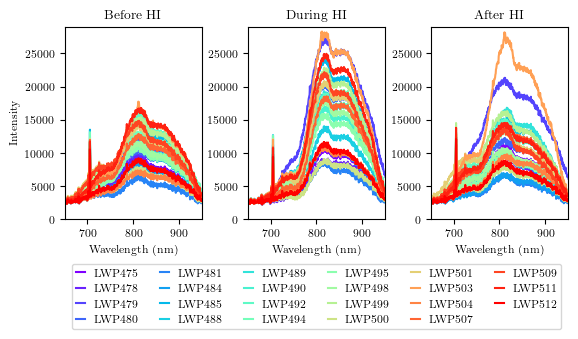

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(6.5,2.5))
colors = mpl.cm.rainbow(np.linspace(0, 1, len(df)))
for i in range(len(df)):

    before = df.HI_start_idx[i] - 30 # 5min before HI
    during = df.HI_start_idx[i] + 90 # 10min after start of HI
    after = df.HI_end_idx[i] + 120 # 15min after end of HI

    if df.piglet[i] == "LWP502":
        continue

    img_mat = scipy.io.loadmat(dataset_path + df.piglet[i] + "/" + df.spectrum[i])
    band_centers = np.asarray(img_mat['wavelengths'].astype(float)).squeeze()
    spectr_before = img_mat['spectralDataAll'].astype(float)[:,before-6:before+6].T # shape (time_steps.shape[0], k)
    spectr_during = img_mat['spectralDataAll'].astype(float)[:,during-6:during+6].T
    spectr_after = img_mat['spectralDataAll'].astype(float)[:,after-6:after+6].T

    axs[0].plot(band_centers, np.mean(spectr_before, axis=0), color=colors[i], label=df.piglet[i].split('-')[0].upper())
    axs[1].plot(band_centers, np.mean(spectr_during, axis=0), color=colors[i], label=df.piglet[i].split('-')[0].upper())
    axs[2].plot(band_centers, np.mean(spectr_after, axis=0), color=colors[i], label=df.piglet[i].split('-')[0].upper())

xlim = [650,950]
ylim = [0, 29000]
axs[0].set_ylabel('Intensity')
axs[0].set_xlabel('Wavelength (nm)')
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)
axs[0].set_title(f"Before HI")
axs[1].set_xlabel('Wavelength (nm)')
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
axs[1].set_title(f"During HI")
axs[2].set_xlabel('Wavelength (nm)')
axs[2].set_xlim(xlim)
axs[2].set_ylim(ylim)
axs[2].set_title(f"After HI")
fig.subplots_adjust(wspace=0.33)
axs[1].legend(bbox_to_anchor=(0.5, -0.57), loc='lower center', borderaxespad=0., ncol=6, handlelength=0.8)

# plt.savefig("../../figures/piglet_raw_spectra_before_during_after.svg", format='svg', bbox_inches='tight')

calibrated data Before, during, and after HI

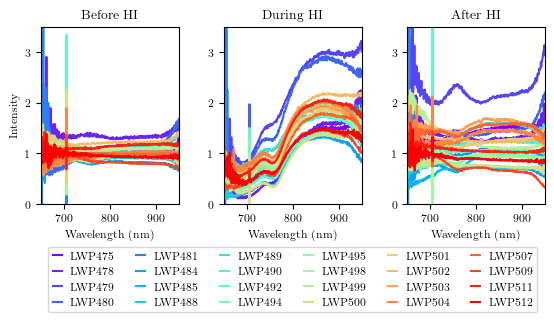

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(6.5,2.3))
colors = mpl.cm.rainbow(np.linspace(0, 1, len(df)))
for i in range(len(df)):

    before = df.HI_start_idx[i] - 30 # 5min before HI
    during = df.HI_start_idx[i] + 90 # 15min after start of HI
    after = df.HI_end_idx[i] + 180 # 30min after end of HI
    
    # load the spectral data
    img_mat = scipy.io.loadmat(dataset_path + df.piglet[i] + "/" + df.spectrum[i])
    band_centers = np.asarray(img_mat['wavelengths'].astype(float)).squeeze()
    spectr = img_mat['spectralDataAll'].astype(float).T # shape (time_steps.shape[0], k)
    white_ref= img_mat['refIntensity'].astype(float) # shape (k,m)
    dark_ref = scipy.io.loadmat(dataset_path + df.piglet[i] + "/" + df.darkCount[i])["DarkCount"].astype(float) # shape (k,n)

    # average dark and white reference and add dimension for shape (1,k)
    white_ref = np.mean(white_ref, axis=-1)[np.newaxis, :]
    dark_ref = np.mean(dark_ref, axis=-1)[np.newaxis, :]

    # extract wavelengths between 600 and 1000
    band_limits = [650,950]
    spectr, _ = band_removal(spectr, band_limits, band_centers)
    white_ref, _ = band_removal(white_ref, band_limits, band_centers)
    dark_ref, band_centers = band_removal(dark_ref, band_limits, band_centers)

    spectr_calib = calibrate_img(spectr, white_ref, dark_ref)
    spectr_before = spectr_calib[before-6:before+6]
    spectr_during = spectr_calib[during-6:during+6]
    spectr_after = spectr_calib[after-6:after+6]

    axs[0].plot(band_centers, np.mean(spectr_before, axis=0), color=colors[i], label=df.piglet[i].split('-')[0].upper())
    axs[1].plot(band_centers, np.mean(spectr_during, axis=0), color=colors[i], label=df.piglet[i].split('-')[0].upper())
    axs[2].plot(band_centers, np.mean(spectr_after, axis=0), color=colors[i], label=df.piglet[i].split('-')[0].upper())
    

ylim = [0, 3.5]
axs[0].set_ylabel('Intensity')
axs[0].set_xlabel('Wavelength (nm)')
axs[0].set_xlim(band_limits)
axs[0].set_ylim(ylim)
axs[0].set_yticks((0,1,2,3))
axs[0].set_title(f"Before HI")
axs[1].set_xlabel('Wavelength (nm)')
axs[1].set_xlim(band_limits)
axs[1].set_ylim(ylim)
axs[1].set_yticks((0,1,2,3))
axs[1].set_title(f"During HI")
axs[2].set_xlabel('Wavelength (nm)')
axs[2].set_xlim(band_limits)
axs[2].set_ylim(ylim)
axs[2].set_yticks((0,1,2,3))
axs[2].set_title(f"After HI")
fig.subplots_adjust(wspace=0.33)
axs[1].legend(bbox_to_anchor=(0.5, -0.61), loc='lower center', borderaxespad=0., ncol=6, handlelength=0.8)

plt.savefig("../../figures/piglet_calib_spectra_before_during_after.svg", format='svg', bbox_inches='tight')

calibrated and normalized data Before, during, and after HI

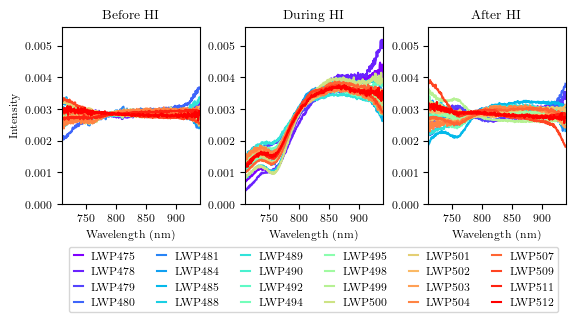

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(6.5,2.3))
colors = mpl.cm.rainbow(np.linspace(0, 1, len(df)))
for i in range(len(df)):

    before = df.HI_start_idx[i] - 30 # 5min before HI
    during = df.HI_start_idx[i] + 90 # 15min after start of HI
    after = df.HI_end_idx[i] + 180 # 30min after end of HI
    
    # load the spectral data
    img_mat = scipy.io.loadmat(dataset_path + df.piglet[i] + "/" + df.spectrum[i])
    band_centers = np.asarray(img_mat['wavelengths'].astype(float)).squeeze()
    spectr = img_mat['spectralDataAll'].astype(float).T # shape (time_steps.shape[0], k)
    white_ref= img_mat['refIntensity'].astype(float) # shape (k,m)
    dark_ref = scipy.io.loadmat(dataset_path + df.piglet[i] + "/" + df.darkCount[i])["DarkCount"].astype(float) # shape (k,n)

    # average dark and white reference and add dimension for shape (1,k)
    white_ref = np.mean(white_ref, axis=-1)[np.newaxis, :]
    dark_ref = np.mean(dark_ref, axis=-1)[np.newaxis, :]

    # extract wavelengths between 750 and 950
    band_limits = [710,940]
    spectr, _ = band_removal(spectr, band_limits, band_centers)
    white_ref, _ = band_removal(white_ref, band_limits, band_centers)
    dark_ref, band_centers = band_removal(dark_ref, band_limits, band_centers)

    spectr_calib = calibrate_img(spectr, white_ref, dark_ref)
    spectr_calib = l1_normalize(spectr_calib)
    spectr_before = spectr_calib[before-6:before+6]
    spectr_during = spectr_calib[during-6:during+6]
    spectr_after = spectr_calib[after-6:after+6]

    axs[0].plot(band_centers, np.mean(spectr_before, axis=0), color=colors[i], label=df.piglet[i].split('-')[0].upper())
    axs[1].plot(band_centers, np.mean(spectr_during, axis=0), color=colors[i], label=df.piglet[i].split('-')[0].upper())
    axs[2].plot(band_centers, np.mean(spectr_after, axis=0), color=colors[i], label=df.piglet[i].split('-')[0].upper())
    

ylim = [0, 0.0056]
axs[0].set_ylabel('Intensity')
axs[0].set_xlabel('Wavelength (nm)')
axs[0].set_xlim(band_limits)
axs[0].set_ylim(ylim)
axs[0].set_xticks((750,800,850,900))
axs[0].set_title(f"Before HI")
axs[1].set_xlabel('Wavelength (nm)')
axs[1].set_xlim(band_limits)
axs[1].set_ylim(ylim)
axs[1].set_xticks((750,800,850,900))
axs[1].set_title(f"During HI")
axs[2].set_xlabel('Wavelength (nm)')
axs[2].set_xlim(band_limits)
axs[2].set_ylim(ylim)
axs[2].set_xticks((750,800,850,900))
axs[2].set_title(f"After HI")
fig.subplots_adjust(wspace=0.33)
axs[1].legend(bbox_to_anchor=(0.5, -0.61), loc='lower center', borderaxespad=0., ncol=6, handlelength=0.8)

plt.savefig("../../figures/piglet_calib_norm_spectra_before_during_after.svg", format='svg', bbox_inches='tight')

White and dark reference

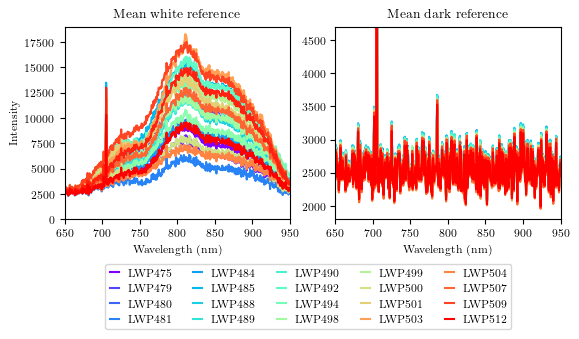

In [163]:
fig, axs = plt.subplots(1, 2, figsize=(6.4,2.5))
colors = mpl.cm.rainbow(np.linspace(0, 1, len(df)))
for i in range(len(df)):

    img_mat = scipy.io.loadmat(dataset_path + df.piglet[i] + "/" + df.spectrum[i])
    band_centers = np.asarray(img_mat['wavelengths'].astype(float)).squeeze()

    # skip piglet with outlier white reference data
    if df.piglet[i] == "LWP502":
        continue
    white_ref= img_mat['refIntensity'].astype(float) # shape (k,m)
    white_ref = np.mean(white_ref, axis=-1)
    axs[0].plot(band_centers, white_ref, color=colors[i], label=df.piglet[i].split('-')[0].upper())

    # skip piglets with missing or broken dark reference data
    if df.piglet[i] == "lwp478" or df.piglet[i] == "LWP495" or df.piglet[i] == "LWP502" or df.piglet[i] == "LWP511":
        continue
    dark_ref = scipy.io.loadmat(dataset_path + df.piglet[i] + "/" + df.darkCount[i])["DarkCount"].astype(float) # shape (k,n)
    dark_ref = np.mean(dark_ref, axis=-1)
    axs[1].plot(band_centers, dark_ref, color=colors[i], label=df.piglet[i].split('-')[0].upper())


axs[0].set_ylabel('Intensity')
axs[0].set_xlabel('Wavelength (nm)')
axs[0].set_xlim([650,950])
axs[0].set_ylim([0, 19000])
axs[0].set_title('Mean white reference')
axs[1].set_xlabel('Wavelength (nm)')
axs[1].set_xlim([650,950])
axs[1].set_ylim([1800,4700])
axs[1].set_title('Mean dark reference')
fig.subplots_adjust(wspace=0.2)
axs[1].legend(bbox_to_anchor=(-0.12, -0.57), loc='lower center', borderaxespad=0., ncol=5, handlelength=0.8)

# plt.savefig("../../figures/piglet_white_dark_reference.svg", format='svg', bbox_inches='tight')